To Do: 
* Next upload: Added Kmeans, operator to imports

# TOC

0. [Imports](#first-bullet)
1. [EDA](#1.0-bullet)
2. [Data Transformation](#2.0-bullet)
3. [Modelling](#3.0-bullet)
4. [Output](#4.0-bullet)

#  <a class="anchor" id="first-bullet">Imports</a>

In [8]:
#Basic
import pandas as pd
import numpy as np
#Math
import scipy as sp
from random import randint
from math import exp
import operator

#Scraping
'''import requests
import json'''

#Modeling
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix

#NLP Processing
'''from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer'''

#Time analysis
import time
import datetime
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

%matplotlib inline

 # <a class="anchor" id="second-bullet">1. EDA</a>

In [9]:
data_spray = pd.read_csv('./Data/spray.csv')
data_weather = pd.read_csv('./Data/weather.csv')
data_train = pd.read_csv('./Data/train.csv')
data_test = pd.read_csv('./Data/test.csv')

In [10]:
#data_weather['weather_day'] = 1
data_spray['spray_day'] = 1
data_spray.columns = ['Date', 'Time', 'Latitude_sp', 'Longitude_sp', 'spray_day']

## 1.2 Feature Analysis

# <a class="anchor" id="2.0-bullet">2. Data Transformation </a>

### 2.1 Weather Slice

In [11]:
weather_station_1 = data_weather.loc[data_weather.Station==1, :]
weather_station_2 = data_weather.loc[data_weather.Station==2, :]

In [12]:
weather_station_1 = weather_station_1.drop('Station', axis=1)
weather_station_2 = weather_station_2.drop('Station', axis=1)

In [13]:
weather_station_1.loc[:, ['Date']] = pd.to_datetime(weather_station_1.Date)
weather_station_2.loc[:, ['Date']] = pd.to_datetime(weather_station_2.Date)

In [14]:
weather_station_1.index = weather_station_1.Date
weather_station_2.index = weather_station_2.Date

### 2.2 Convert Weather Objects

In [15]:
weather_station_1.loc[:, ['Tavg']] = \
weather_station_1['Tavg'].astype('float64')
weather_station_1.loc[:, ['PrecipTotal']] = \
weather_station_1['PrecipTotal'].map(lambda x: .001 if x=='  T' else x).astype(float)
weather_station_1.loc[:, ['SnowFall']] = \
weather_station_1['SnowFall'].map(lambda x: .001 if x=='  T' else x).astype(float)

weather_station_1 = weather_station_1.drop('Depart', axis=1)
weather_station_1 = weather_station_1.drop('Water1', axis=1)

In [16]:
#Create dummy columns for weather codes

#list all columns
templist = [element for element in weather_station_1['CodeSum'].str.split(' ').tolist()]
newl = []
#get all tags
for element in templist:
    for subelement in element:
        newl.append(subelement)
Codes_list = list(set(newl))
Codes_list.pop(0)

#Create new columns and score 1 if present in original CodeSum value
for code in Codes_list:
    weather_station_1.loc[:, code] = weather_station_1['CodeSum'].str.contains(code)*1
weather_station_1 = weather_station_1.drop('CodeSum', axis=1)

In [17]:
#find means without 'M' values and fill in blank - less than 5 for each
stnpressure_mean = weather_station_1[weather_station_1['StnPressure']!='M']['StnPressure'].astype(float).mean()
sealevel_mean = weather_station_1[weather_station_1['SeaLevel']!='M']['SeaLevel'].astype(float).mean()
wetbulb_mean = weather_station_1[weather_station_1['WetBulb']!='M']['WetBulb'].astype(float).mean()

In [18]:
#Replace M with mean, leave others alone
weather_station_1.loc[:, 'StnPressure'] = \
weather_station_1['StnPressure'].map(lambda x: stnpressure_mean if x=='M' else x).astype(float);

weather_station_1.loc[:, 'SeaLevel'] = \
weather_station_1['SeaLevel'].map(lambda x: sealevel_mean if x=='M' else x).astype(float)

weather_station_1.loc[:, 'WetBulb'] = \
weather_station_1['WetBulb'].map(lambda x: wetbulb_mean if x=='M' else x).astype(float);

In [19]:
#Convert remaining cols to float. Leftover errors from station 1 (Ohare)
obj_cols = [col for col in weather_station_1.columns if weather_station_1[col].dtype=='object']
for col in weather_station_1:
    if col in obj_cols:
        weather_station_1.loc[:, col] = weather_station_1[col].astype('float64')

### 2.2 Training Data Munging

In [20]:
df_train = data_train #Don't edit the initial frame. For recovery

#### 2.2.1 Time Series

#### 2.2.1.1 Establishing Basic Features

In [21]:
#Convert to Date Time from object
df_train.loc[:, ['Date']]= pd.to_datetime(df_train['Date'])

#Switch to DateTime Index
df_train.index = df_train.Date

#Create Days from start column for easy analysis
BeginDate = datetime.date(2007, 4, 30)
df_train.loc[:, 'DaysFrom'] = df_train.index - pd.to_datetime(BeginDate)
#extract date number from datetime entry. Should capture broad time dependence
df_train.loc[:, 'DaysFrom'] = df_train['DaysFrom'].astype(str).str.replace(' days 00:00:00.000000000', '').astype(int)
#Extract Month information
df_train.loc[:, 'Month'] = df_train.index.month

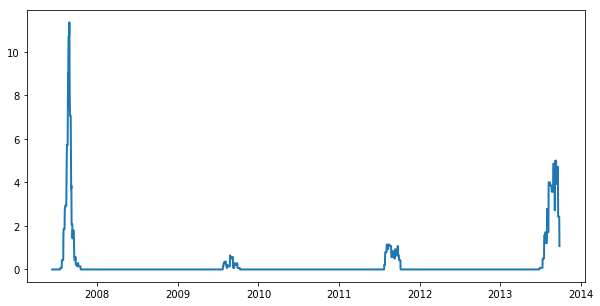

In [22]:
plt.figure(figsize=(10,5))
plt.plot(df_train['WnvPresent'].resample('D').sum().rolling(window=14).mean(), alpha=1, lw=2)

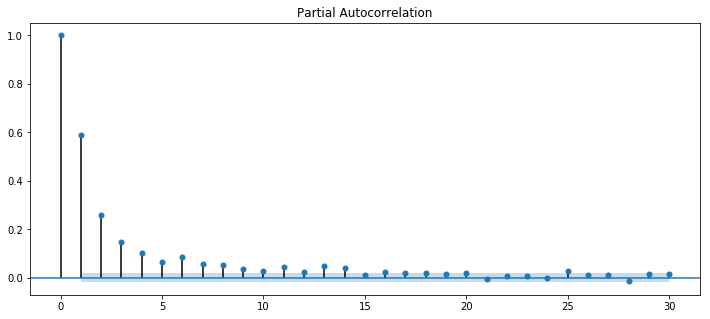

In [23]:
fig, ax = plt.subplots(figsize=(12,5))
plot_pacf(df_train.NumMosquitos, lags=30, ax=ax)
plt.show()

In [24]:
#sig bumps at 1,2. bumps at 14, 30
wnv_rolling_1 = df_train['WnvPresent'].resample('D').sum().rolling(window=1).mean()
wnv_rolling_2 = df_train['WnvPresent'].resample('D').sum().rolling(window=2).mean()
wnv_rolling_14 = df_train['WnvPresent'].resample('D').sum().rolling(window=14).mean()
wnv_rolling_30 = df_train['WnvPresent'].resample('D').sum().rolling(window=30).mean()

In [25]:
numM_rolling_1 = df_train['WnvPresent'].resample('D').sum().rolling(window=1).mean()
numM_rolling_2 = df_train['WnvPresent'].resample('D').sum().rolling(window=2).mean()
numM_rolling_6 = df_train['WnvPresent'].resample('D').sum().rolling(window=6).mean()
numM_rolling_13 = df_train['WnvPresent'].resample('D').sum().rolling(window=13).mean()

#### 2.2.1.2 Seasonal Adjustments to Baseline Probability

In [26]:
#Create a normalized graph to observe seasonality across years
year_day = pd.DataFrame(df_train.index.dayofyear)
year_day['Wnv'] = pd.DataFrame(df_train['WnvPresent']).reset_index().drop('Date', axis=1)
#Total number of occurences by day of the year
daily_sums = year_day.groupby(by='Date').sum()

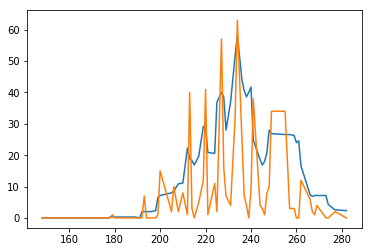

In [27]:
#Shift up two days to capture Friday-Monday jump
#2 seems to be an appropriate normalization factor
normizer = 2
rolls = pd.Series([daily_sums.iloc[row-5:row+2].mean().sum()*normizer for row in range(len(daily_sums))])
rolls.index = daily_sums.index
plt.plot(rolls)
plt.plot(year_day.groupby(by='Date').sum());#confirm this is from skipped weekends or something

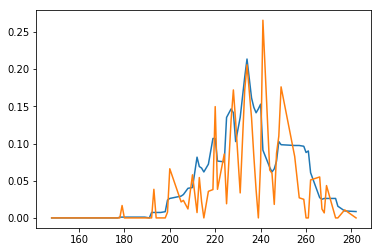

In [28]:
#Normalize by total rows used in calculation
rolling_count = year_day.groupby(by='Date').count()
rolling_average_rate = rolls / rolling_count['Wnv'].mean()/normizer
plt.plot( rolling_average_rate)
plt.plot(year_day.groupby(by='Date').sum() /rolling_count)

In [29]:
#Add measurement back in 
df_train['YearDay'] = df_train.index.dayofyear

rolling_average_rate = pd.DataFrame(rolling_average_rate, columns=['seasonal_baseline'])

df_train = df_train.join(rolling_average_rate, on='YearDay', how='left')

#### 2.2.2 Dummy Columns

In [34]:
df_species_dummies = pd.get_dummies(df_train['Species'])

df_block_dummies = pd.get_dummies(df_train['Block'])

df_trap_dummies = pd.get_dummies(df_train['Trap'])

In [35]:
df_weekday_dummies = pd.get_dummies(df_train.index.weekday_name)
df_weekday_dummies.index=df_train.index

In [36]:
#Assess Weekday Correlation
week_trap = pd.concat([df_weekday_dummies,df_trap_dummies], axis=1)
week_trap_corr = week_trap.corr()
week_trap_corr = np.triu(week_trap_corr, k=1)[:5]

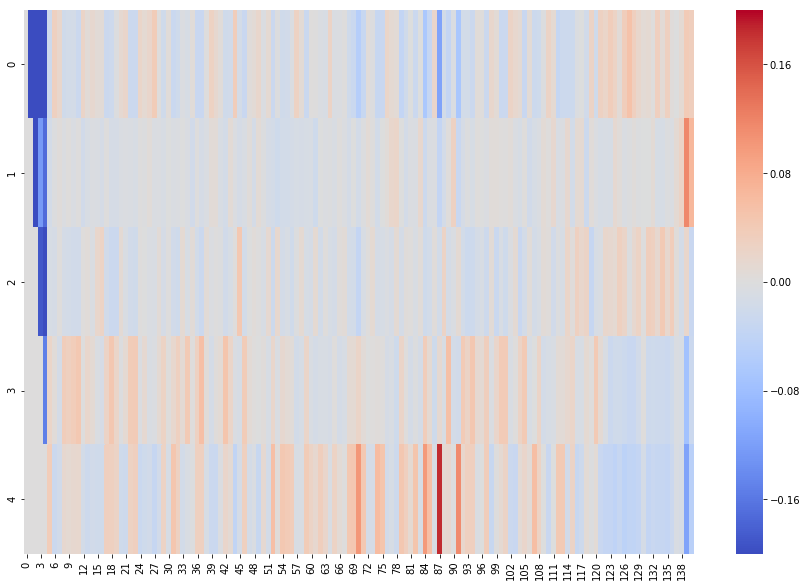

In [37]:
fig, axes = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(15)
sns.heatmap(week_trap_corr, cmap='coolwarm', vmin=-.2, vmax=.2, ax=axes)

In [38]:
temp_df = pd.concat([df_train, df_trap_dummies, df_species_dummies], axis=1)
temp_df['weekday'] = temp_df.index.weekday

In [39]:
df_train.index.weekday_name.value_counts()

Friday       3764
Thursday     2576
Wednesday    1795
Monday       1315
Tuesday      1056
Name: Date, dtype: int64

In [40]:
#temp_df.to_csv('./Data/weekday.csv', index=False)

#### 2.2.3 Remove Un-Needed and Recombine

In [41]:
cols_to_drop = ['Address', 'Species', 'Block', 'Street', 'Trap', 'AddressNumberAndStreet', 'AddressAccuracy', 'Date']

In [42]:
df_train = df_train.drop(cols_to_drop, axis=1)

Series to add 
  West Nile Rolling prevalence
wnv_rolling_1   
wnv_rolling_2  
wnv_rolling_14  
wnv_rolling_30  
  Rolling Mosquito counts  
numM_rolling_1   
numM_rolling_2   
numM_rolling_6   
numM_rolling_13   

DataFrame Dummies to add  
df_species_dummies  
df_block_dummies  
df_trap_dummies  

In [43]:
#CAUTION: JOINING DATAFRAMES IS MEMORY INTENSIVE

In [44]:
#YOU HAVE BEEN WARNED

In [45]:
df_train = pd.concat([df_train,df_species_dummies, df_weekday_dummies], axis=1)

In [29]:
#Add measurement back in 
df_train['YearDay'] = df_train.index.dayofyear

rolling_average_rate = pd.DataFrame(rolling_average_rate, columns=['seasonal_baseline'])

df_train = df_train.join(rolling_average_rate, on='YearDay', how='left')

In [46]:
df_temp = data_test

In [47]:

#Convert to Date Time from object
df_temp.loc[:, ['Date']]= pd.to_datetime(df_temp['Date'])

#Switch to DateTime Index
df_temp.index = df_temp.Date

In [48]:
df_temp.shape[0]

116293

In [49]:
test_freq = df_temp.index.weekday.value_counts().sort_index() / df_temp.shape[0]
train_freq = df_train.index.weekday.value_counts().sort_index() / df_train.shape[0]

In [50]:
df_freq = pd.DataFrame(test_freq)

In [51]:
df_freq['Day'] = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
df_freq['Set'] = 'Test'

In [52]:
df_freq_2 = pd.DataFrame(train_freq)
df_freq_2['Day'] = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
df_freq_2['Set'] = 'Train'

In [53]:
df_freq = pd.concat([df_freq, df_freq_2])
df_freq = df_freq.reset_index()
df_freq = df_freq.drop('index', axis=1)

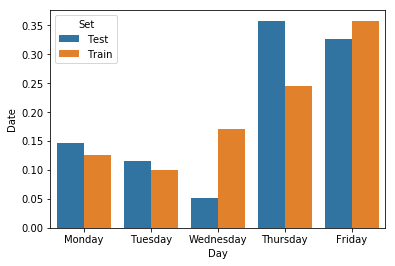

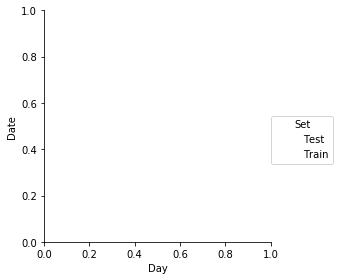

In [54]:
fig, axes = plt.subplots()
fig.set_figwidth = 10
fig.set_figheight = 10
sns.factorplot(x='Day', y = 'Date', hue='Set',  data=df_freq, kind='bar', ax=axes)

## 2.9 Combine Data and Assess

In [55]:
df_rolling = weather_station_1.resample('D').sum().rolling(window=7).mean().shift()

In [56]:
df_train = df_train.join(df_rolling, how='left')

In [57]:
df_train.head()

Latitude  Longitude  NumMosquitos  WnvPresent  DaysFrom  Month  \
Date                                                                          
2007-05-29  41.954690 -87.800991             1           0        29      5   
2007-05-29  41.954690 -87.800991             1           0        29      5   
2007-05-29  41.994991 -87.769279             1           0        29      5   
2007-05-29  41.974089 -87.824812             1           0        29      5   
2007-05-29  41.974089 -87.824812             4           0        29      5   

            YearDay  seasonal_baseline  CULEX ERRATICUS  CULEX PIPIENS ...   \
Date                                                                   ...    
2007-05-29      149                0.0                0              0 ...    
2007-05-29      149                0.0                0              0 ...    
2007-05-29      149                0.0                0              0 ...    
2007-05-29      149                0.0                0              0 ...    
2007-05-29      149                0.0                0              0 ...    

                  RA        BR        TS      TSRA  MIFG  BCFG   FU  FG+   SQ  \
Date                                                                            
2007-05-29  0.571429  0.285714  0.142857  0.142857   0.0   0.0  0.0  0.0  0.0   
2007-05-29  0.571429  0.285714  0.142857  0.142857   0.0   0.0  0.0  0.0  0.0   
2007-05-29  0.571429  0.285714  0.142857  0.142857   0.0   0.0  0.0  0.0  0.0   
2007-05-29  0.571429  0.285714  0.142857  0.142857   0.0   0.0  0.0  0.0  0.0   
2007-05-29  0.571429  0.285714  0.142857  0.142857   0.0   0.0  0.0  0.0  0.0   

             FG  
Date             
2007-05-29  0.0  
2007-05-29  0.0  
2007-05-29  0.0  
2007-05-29  0.0  
2007-05-29  0.0  

[5 rows x 51 columns]

# <a class="anchor" id="3.0-bullet">3. Model </a>

## 3.1 Build Model

In [58]:
cols_to_exclude = ['WnvPresent', 'NumMosquitos', 'DaysFrom', 
                   'Sunrise', 'Sunset', 'YearDay', 'Month', 'seasonal_baseline']
model_cols = [col for col in df_train.columns if col not in cols_to_exclude]

In [59]:
X = df_train.loc[:, model_cols]
y = df_train['WnvPresent']

In [61]:
#Stratification on Days From should ensure usable spread in time data. Should get most periods in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=X.index, random_state=42)

### 3.1.2 GridSearch KKN

In [62]:
paramz = {
    'n_neighbors': [3, 5, 7, 8, 20]
}
gs=GridSearchCV(KNeighborsClassifier(), param_grid=paramz)
gs.fit(X_train, y_train)
print('   Score: ', gs.score(X_test, y_test))


   Score:  0.9444232965359726


In [63]:
gs.best_params_

{'n_neighbors': 8}

In [64]:
#Option 2: Use Something Else
knc = KNeighborsClassifier(8)
knc.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=8, p=2,
           weights='uniform')

In [65]:
kpreds = knc.predict_proba(X_test)

In [66]:
wnv_preds = [proba[1] for proba in kpreds]

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


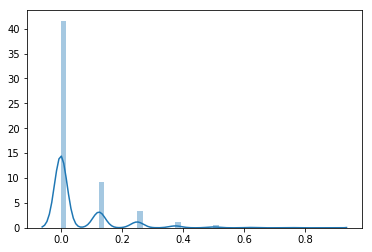

In [67]:
wnv_preds_adj = [1*(pred > .1) for pred in wnv_preds]
sns.distplot(wnv_preds)

In [68]:
cm = confusion_matrix(y_test, wnv_preds_adj)
df_cm = pd.DataFrame(cm, columns=['Predicted 0', 'Pred 1'], index=['Actual 0', 'Actual 1'])
df_cm

Predicted 0  Pred 1
Actual 0         1901     581
Actual 1           51      94

In [69]:
X_test_mod = X_test

In [88]:
X_train.columns

Index(['Latitude', 'Longitude', 'CULEX ERRATICUS', 'CULEX PIPIENS',
       'CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX SALINARIUS',
       'CULEX TARSALIS', 'CULEX TERRITANS', 'Friday', 'Monday', 'Thursday',
       'Tuesday', 'Wednesday', 'Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb',
       'Heat', 'Cool', 'Depth', 'SnowFall', 'PrecipTotal', 'StnPressure',
       'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed', 'HZ', 'DZ', 'VCTS',
       'SN', 'RA', 'BR', 'TS', 'TSRA', 'MIFG', 'BCFG', 'FU', 'FG+', 'SQ',
       'FG'],
      dtype='object')

In [89]:
[col for col in X_test.columns if col not in X_train.columns]

['YearDay']

In [70]:
X_test_mod['YearDay'] =X_test_mod.index.dayofyear

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [71]:
X_test_mod= X_test_mod.join(rolling_average_rate, on='YearDay', how='left')

In [72]:
wnv_preds2 = [X_test_mod['seasonal_baseline'][i] + wnv_preds[i] for i in range(len(X_test_mod))]

In [73]:
wnv_preds_adj2 = [1*(pred > .1) for pred in wnv_preds2]


In [74]:
cm = confusion_matrix(y_test, wnv_preds_adj2)
df_cm = pd.DataFrame(cm, columns=['Predicted 0', 'Pred 1'], index=['Actual 0', 'Actual 1'])
df_cm

Predicted 0  Pred 1
Actual 0         1623     859
Actual 1           24     121

In [75]:
from sklearn.metrics import roc_auc_score

In [76]:
roc_auc_score(y_test, wnv_preds)

0.731430437077996

In [77]:
for i in range(1, 90, 5):
    print('    i:{} score:{}'.format(i, roc_auc_score(y_test, [1*(pred > i/100) for pred in wnv_preds2])))

    i:1 score:0.650459862735836
    i:6 score:0.6941634944010671
    i:11 score:0.7385909583483843
    i:16 score:0.7265053210703271
    i:21 score:0.728153046764289
    i:26 score:0.6811220095029036
    i:31 score:0.6570910556003223
    i:36 score:0.6139820500708549
    i:41 score:0.6035899858290034
    i:46 score:0.5802342382394621
    i:51 score:0.5489510683820057
    i:56 score:0.5475172969518464
    i:61 score:0.5237586484759232
    i:66 score:0.5237586484759232
    i:71 score:0.5211161743866182
    i:76 score:0.51623412709439
    i:81 score:0.5166370279807719
    i:86 score:0.5101433771430159


In [78]:
for i in range(1, 90, 5):
    print('    i:{} score:{}'.format(i, roc_auc_score(y_test, [1*(pred > i/100) for pred in wnv_preds])))

    i:1 score:0.7070952235405262
    i:6 score:0.7070952235405262
    i:11 score:0.7070952235405262
    i:16 score:0.6619258662369057
    i:21 score:0.6619258662369057
    i:26 score:0.5771652449359527
    i:31 score:0.5771652449359527
    i:36 score:0.5771652449359527
    i:41 score:0.5399927755703131
    i:46 score:0.5399927755703131
    i:51 score:0.522526327488955
    i:56 score:0.522526327488955
    i:61 score:0.522526327488955
    i:66 score:0.5133902025618939
    i:71 score:0.5133902025618939
    i:76 score:0.503448275862069
    i:81 score:0.503448275862069
    i:86 score:0.503448275862069


### 3.1.4 Nearest Centroid

In [79]:
from sklearn.neighbors.nearest_centroid import NearestCentroid

In [80]:
clf = NearestCentroid()
clf.fit(X_train, y_train)

NearestCentroid(metric='euclidean', shrink_threshold=None)

In [84]:
X_train.shape

(7879, 43)

In [94]:
X_test.drop('YearDay', axis =1, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [95]:
clf.score(X_test, y_test)

0.5709935287400076

In [96]:
roc_auc_score(y_test, clf.predict(X_test))

0.5651685237155798

### 3.1.5 Manual Centroids

In [ ]:
checkn = 100
kmm = KMeans(n_clusters = checkn)

In [ ]:
k_data = pd.concat([X_train, y_train], axis=1)

In [ ]:
#Update Target column with descriptive name
k_cols = list(k_data.columns)
k_cols.append('Target')
k_cols.pop(len(k_cols)-2)
k_data.columns = k_cols

In [ ]:
kmm.fit(k_data)

In [ ]:
centroids = pd.DataFrame(kmm.cluster_centers_, columns=k_data.columns)

In [ ]:
(centroids['Target']*100).astype(int).sort_values(ascending=False)[:5]

In [ ]:
df_temp = centroids.iloc[[12,16,92],  :].T
for col in df_temp.columns:
    df_temp.loc[:, col] = df_temp[col].map(lambda x: '{:01f}'.format(x))
df_temp = pd.concat([k_data.mean(), df_temp], axis=1)

In [ ]:
df_temp

### 3.1.5 Random Forrest Classifier

In [97]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
roc_auc_score(y_test, rfc.predict(X_test))

0.5540345661174247

## 3.2 Assess Model

In [ ]:
cm = confusion_matrix(y_test, gs.predict(X_test))
df_cm = pd.DataFrame(cm, columns=['Predicted 0', 'Pred 1'], index=['Actual 0', 'Actual 1'])
df_cm

In [ ]:
centroids[centroids['Target']<.001].T.shape
#There 41 of the most common groups are straight 

In [ ]:
sns.distplot(pd.DataFrame(knc.predict_proba(X_test)).iloc[:, 1])

# <a class="anchor" id="4.0-bullet">4. Output</a>

## 4.1 Transform test data

In [110]:
df_test = data_test

In [111]:
df_test.shape

(116293, 14)

### 4.1.3 Time Series

In [101]:
#Transform index to time

In [102]:
#Convert to Date Time from object
df_test.loc[:, ['Date']]= pd.to_datetime(df_test['Date'])

#Switch to DateTime Index
df_test.index = df_test.Date

#Create Days from start column for easy analysis

df_test.loc[:, 'DaysFrom'] = df_test.index - pd.to_datetime(BeginDate)
#extract date number from datetime entry. Should capture broad time dependence
df_test.loc[:, 'DaysFrom'] = df_test['DaysFrom'].astype(str).str.replace(' days 00:00:00.000000000', '').astype(int)
#Extract Month information
df_test.loc[:, 'Month'] = df_test.index.month

In [ ]:
#Get weekday dummies
df_test_weekday = pd.get_dummies(df_test.index.weekday_name)

In [ ]:
#Create seasonal baseline for add back

In [112]:
#Add measurement back in 
df_test['YearDay'] = df_test.index.dayofyear

In [128]:
temp = df_test.join(rolling_average_rate, on='YearDay', how='left')

In [133]:
#come back to this - need to fill in blank for seasonal_baseline

In [135]:
rolling_average_rate.index

Int64Index([148, 149, 153, 154, 156, 158, 161, 163, 165, 166, 168, 170, 172,
            173, 175, 177, 178, 179, 180, 181, 183, 187, 189, 191, 192, 193,
            194, 196, 198, 199, 200, 205, 206, 208, 210, 212, 213, 214, 215,
            217, 219, 220, 221, 224, 225, 227, 228, 229, 231, 233, 234, 236,
            237, 238, 239, 240, 241, 244, 245, 246, 247, 248, 249, 255, 257,
            259, 260, 261, 262, 266, 267, 268, 269, 273, 274, 277, 282],
           dtype='int64', name='Date')

### 4.1.3 Categorical

In [ ]:
df_test_species

### 4.1.3 Weather

In [105]:
#df_test = df_test.join(df_rolling, how='left')

## 4.2 Predict

## 4.3 Asses